<a href="https://colab.research.google.com/github/ekaterinagolowatenko/Neural_network/blob/main/Hot_dog_Not_hot_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
rand_state = 42
tf.random.set_seed(rand_state)#глобальное зерно случайности
np.random.seed(rand_state) #устанавливает зерно для всех случайных операций в NumPy
from skimage import exposure
import cv2
import glob
import time
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import kagglehub

In [ ]:
path = kagglehub.dataset_download("dansbecker/hot-dog-not-hot-dog")

100%|██████████| 89.3M/89.3M [00:00<00:00, 132MB/s]

Extracting files...


In [ ]:
#работас изображениями
def rotateImage(img, angle):
    (rows, cols, ch) = img.shape #ch - цветовые каналы
    M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1) #cols/2,rows/2 - находит центр картикни. 1 -  означает: "не увеличивай и не уменьшай картинку при повороте"
    return cv2.warpAffine(img, M, (cols,rows))


def loadBlurImg(path, imgSize):
    img = cv2.imread(path)
    angle = np.random.randint(0, 360) #случайный угол
    img = rotateImage(img, angle)
    img = cv2.blur(img,(5,5)) #Картинка делается нечёткой + 5,5 - сила размытия
    img = cv2.resize(img, imgSize) #подгоняем под один размер
    return img

def loadImgClass(classPath, classLable, classSize, imgSize):
    x = [] #будут складываться картинки
    y = []#будут складываться метки

    for path in classPath: #берёт каждый путь к картинке,  загружает и обрабатывает её через loadBlurImg, Складывает в список x и метку в список y
        img = loadBlurImg(path, imgSize)
        x.append(img)
        y.append(classLable)

    while len(x) < classSize: #аугментация данных (если не хватает картинок, выбирает случайную и еще раз ее обрабатывает через loadBlurImg)
        randIdx = np.random.randint(0, len(classPath))
        img = loadBlurImg(classPath[randIdx], imgSize)
        x.append(img)
        y.append(classLable)

    return x, y #опять возвращает 2 списка

def loadData(img_size, classSize, hotdogs, notHotdogs):
    imgSize = (img_size, img_size) #устанавливается размер картинки
    xHotdog, yHotdog = loadImgClass(hotdogs, 0, classSize, imgSize)
    xNotHotdog, yNotHotdog = loadImgClass(notHotdogs, 1, classSize, imgSize)
    print("There are", len(xHotdog), "hotdog images")
    print("There are", len(xNotHotdog), "not hotdog images")

    X = np.array(xHotdog + xNotHotdog)#все картинки с хот-догами и не-хот-догами складываются в один массив х
    y = np.array(yHotdog + yNotHotdog) #и все метки тоже

    return X, y #готовые данные для обучения нейросети

def toGray(images): #: 0.2989*R + 0.5870*G + 0.1140*B итоговое значение яркости пикселя в градациях серого
    # источник https://www.mathworks.com/help/matlab/ref/rgb2gray.html

    images = 0.2989*images[:,:,:,0] + 0.5870*images[:,:,:,1] + 0.1140*images[:,:,:,2] #преобразование в grayscale уменьшает размер входных данных (с 3 каналов до 1)
    return images

def normalizeImages(images):
    images = (images / 255.).astype(np.float32) #все пиксели картинки делятся на 255, чтобы их значения были от 0.0 (чёрный) до 1.0 (белый)

    for i in range(images.shape[0]): #выравнивание гистограммы, чтобы получить лучший диапазон. источник http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
        images[i] = exposure.equalize_hist(images[i]) #тёмные места становятся светлее, а светлые — ярче, чтобы детали были лучше видны

    images = images.reshape(images.shape + (1,)) #добавляет третью размерность (нейросеть ожидает данные в таком формате)
    return images

def preprocessData(images): #объединяет два этапа: сначала делает изображения серыми, потом нормализует и улучшает контраст
    grayImages = toGray(images)
    return normalizeImages(grayImages)


In [ ]:
from tensorflow.keras.utils import to_categorical #преобразовывает метки из 0 и 1 в [1.0] [0.1]
from sklearn.model_selection import train_test_split

size = 32 #уменьшены до 32x32
classSize = 20000 #Для каждого класса нужно 20000 картинок. Если в папке меньше - аугментация

hotdogs = glob.glob(f'{path}/seefood/train/hot_dog/*.jpg') + \
          glob.glob(f'{path}/seefood/test/hot_dog/*.jpg')

notHotdogs = glob.glob(f'{path}/seefood/train/not_hot_dog/*.jpg') + \
             glob.glob(f'{path}/seefood/test/not_hot_dog/*.jpg')

scaled_X, y = loadData(size, classSize, hotdogs, notHotdogs) #Запускается функция loadData
scaled_X = preprocessData(scaled_X)
y = to_categorical(y)


n_classes=2 #разделение данных на 2 класса хот-дог и не-хот-дог
print("y shape", y.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)

print("train shape X", X_train.shape)
print("train shape y", y_train.shape)
print("Test shape X:", X_test.shape)
print("Test shape y: ", y_test.shape)

inputShape = (size, size, 1)

There are 20000 hotdog images
There are 20000 not hotdog images
y shape (40000, 2)
train shape X (32000, 32, 32, 1)
train shape y (32000, 2)
Test shape X: (8000, 32, 32, 1)
Test shape y:  (8000, 2)


In [ ]:
def plot_history(history): #смотрит на все метрики из истории обучения и сортирует их на 4 группы. анализ истории обучения
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss нет в истории обучения')
        return

    epochs = range(1,len(history.history[loss_list[0]]) + 1) #количество эпох ( нужно для подписи оси X на графиках)

    plt.figure(1) #1 график
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend() #подпись к графику

    plt.figure(2) #2ой график
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,202 (1.35 MB)

 Trainable params: 355,202 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Execution time:  384.2952001094818


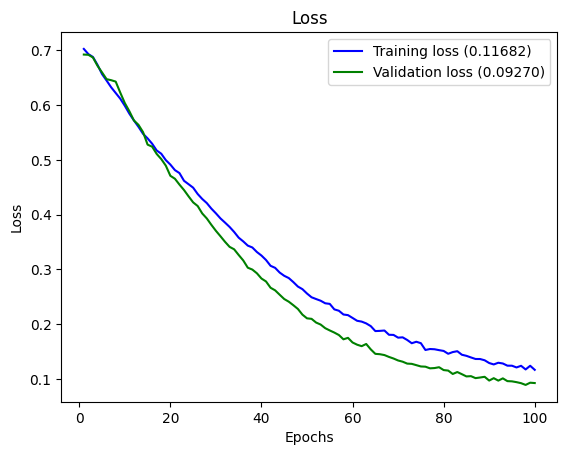

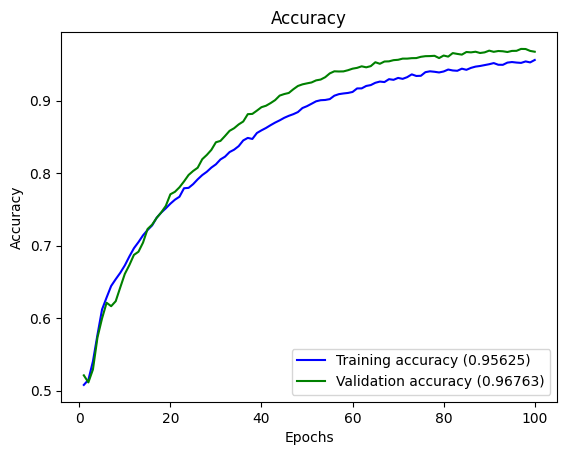

In [ ]:
import keras
from keras.models import Sequential #слои нейросети ставятся один за другим в последовательности
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten #Conv2D - свёрточные слои (ищут паттерны в изображениях). MaxPooling2D уменьшает размер изображения, оставляя самые важные признаки. Dense - полносвязные слои (классифицируют признаки). Flatten  преобразует 2D-картинку в 1D-вектор для полносвязных слоёв.
from tensorflow.keras.layers import BatchNormalization #слой нормализации батчей(пока не использую)


model = Sequential() #создаем пустую модель
model.add(Conv2D(32, kernel_size=(3, 3), #32 - количество фильтров, kernel_size=(3, 3) - размер "окна" для анализа изображения
                 activation='relu',
                 kernel_initializer='he_normal', #способ инициализации весов (рекомендуется для relu)
                 input_shape=inputShape)) # размер входного изображения
model.add(MaxPooling2D((2, 2))) # слой пул-слоя
model.add(Dropout(0.25)) # "отключает" 25% нейронов во время обучения
model.add(Conv2D(64, (3, 3), activation='relu'))  #второй блок свёртки + пулинг + dropout
model.add(MaxPooling2D(pool_size=(2, 2))) #чем глубже слой, тем сложнее признаки он распознаёт (от краёв — к формам объектов)
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu')) #Третий свёрточный слой
model.add(Dropout(0.4)) #в глубоких слоях больше риск переобучения
model.add(Flatten()) #Выпрямление признаков. Преобразует 3D-тензор в 1D-вектор, готовит данные для полносвязных слоёв
model.add(Dense(128, activation='relu')) #Полносвязный слой
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) #Выходной слой. softmax превращает значения в вероятности: сумма = 1.

model.compile(loss=keras.losses.binary_crossentropy, #Компиляция модели. optimizer=Adam(learning_rate=1e-4) алгоритм оптимизации с малым шагом обучения (0.0001)
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

start = time.time()

model.summary()


callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='model.keras', monitor='val_accuracy', save_best_only=True)]

history = model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=100,
                      callbacks=callbacks,
                      verbose=0,
                      validation_data=(X_test, y_test))

end = time.time()
print('Execution time: ', end-start)

plot_history(history)